<a href="https://colab.research.google.com/github/JackyLiu47/memeBlip/blob/main/memeBlip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvcc --version
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install ftfy regex tqdm
!pip install yacs
!pip install torch transformers pytorch-lightning
!pip install --upgrade pytorch-lightning optuna optuna-integration

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
# !pip install numba

# from numba import cuda
# device = cuda.get_current_device()
# device.reset()
import torch

print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
print("Device Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA Available: True
CUDA Device Count: 1
Current Device: 0
Device Name: NVIDIA A100-SXM4-40GB


In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torchmetrics
from transformers import BlipProcessor, BlipForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import pandas as pd
from yacs.config import CfgNode
import numpy as np
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
class Custom_Dataset(Dataset):
    def __init__(self, cfg, root_folder, dataset, label, split='train', image_size=224, fast=True):
        super(Custom_Dataset, self).__init__()
        self.cfg = cfg
        self.root_folder = root_folder
        self.dataset = dataset
        self.split = split
        self.label = label

        self.image_size = image_size
        self.fast = fast

        self.info_file = cfg.info_file
        self.df = pd.read_csv(self.info_file)
        self.df = self.df[self.df['split'] == self.split].reset_index(drop=True)

        if self.label == 'target':
            self.df = self.df[self.df['hate'] == 1].reset_index(drop=True)

        float_cols = self.df.select_dtypes(float).columns
        self.df[float_cols] = self.df[float_cols].fillna(-1).astype('Int64')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        if row['text'] == 'None':
            text = 'null'
        else:
            text = row['text']

        image_fn = row['name']
        try:
            image = Image.open(f"{self.cfg.img_folder}/{image_fn}").convert('RGB')
            image = image.resize((self.image_size, self.image_size))
        except Exception as e:
            raise ValueError(f"Error loading image {image_fn}: {e}")

        item = {
        'image': image,
        'text': text,
        'label': row[self.label],
        'idx_meme': row['name'],
        }
        # print(f"Text length: {len(text)}")
        # if len(text) > 512:
        #     print(f"Warning: Truncated text: {text[:512]}")
        # print(f"Dataset item: {item.keys()}")  # 打印 keys
        return item

In [ ]:
class Custom_Collator(object):
    def __init__(self, cfg):
        self.cfg = cfg
        self.processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

    def __call__(self, batch):
        images = [item['image'] for item in batch]
        texts = [item['text'] for item in batch]
        labels = torch.LongTensor([item['label'] for item in batch])
        # print(f"Labels content: {labels}")  # 打印标签内容
        # print(f"Labels type: {type(labels)}")  # 打印标签类型
        # print(f"Labels device before transfer: {torch.LongTensor(labels).device}")  # 打印设备

        # 使用 BLIP Processor 处理图像和文本
        inputs = self.processor(
            images=images,
            text=texts,
            return_tensors="pt",
            padding="max_length",  # 填充到最大长度
            truncation=True,       # 截断超过最大长度的文本
            max_length=512         # 设置最大长度
        )
        # print(f"Processor outputs keys: {inputs.keys()}")
        # print(f"Pixel values shape: {inputs['pixel_values'].shape}")
        # print(f"Pixel values dtype: {inputs['pixel_values'].dtype}")

        # 确保处理后的张量在正确的设备上
        inputs["pixel_values"] = inputs["pixel_values"].to(self.cfg.device)
        inputs["input_ids"] = inputs["input_ids"].to(self.cfg.device)
        inputs["attention_mask"] = inputs["attention_mask"].to(self.cfg.device)

        return {
            'pixel_values': inputs['pixel_values'],  # 预处理后的图像
            'input_ids': inputs['input_ids'],        # 预处理后的文本
            'attention_mask': inputs['attention_mask'],  # 文本注意力掩码
            'labels': labels,                         # 标签
        }


In [ ]:
from transformers import BlipProcessor, BlipModel, BlipConfig
import torch

class MemeBLIP_Collator:
    def __init__(self, cfg):
        self.cfg = cfg
        # 修改配置
        blipconfig = BlipConfig.from_pretrained("Salesforce/blip-image-captioning-base")
        blipconfig.max_position_embeddings = 1024  # 增加最大序列长度
        # 初始化 BLIP 模型和处理器
        self.processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        self.blip_model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base", config=blipconfig).to(self.cfg.device)
        self.blip_model.eval()

    def __call__(self, batch):
        # 准备存储的特征列表
        image_features_list = []
        text_features_list = []

        labels = torch.LongTensor([item['label'] for item in batch])
        idx_memes = [item['idx_meme'] for item in batch]

        batch_new = {'labels': labels,
                     'idx_memes': idx_memes,
                     }

        for item in batch:
            # 图像处理
            processed = self.processor(images=item['image'], text=item['text'], return_tensors="pt", max_length=512, Truncation = True).to(self.cfg.device)

            # 特征提取
            image_features, text_features = self.compute_features(processed)

            # 收集特征
            image_features_list.append(image_features.cpu().detach())
            text_features_list.append(text_features.cpu().detach())

        # 合并特征
        batch_new['image_features'] = torch.cat(image_features_list, dim=0),
        batch_new['text_features'] = torch.cat(text_features_list, dim=0),

        return batch_new

    def compute_features(self, processed):
        # 从 BLIP 提取视觉和文本特征
        outputs = self.blip_model(**processed)
        image_features = outputs.vision_model_output.last_hidden_state.mean(dim=1)  # 平均池化图像特征
        text_features = outputs.text_model_output.last_hidden_state.mean(dim=1)    # 平均池化文本特征

        return image_features, text_features


In [ ]:
def load_dataset(cfg, split):
    dataset = Custom_Dataset(
        cfg=cfg,
        root_folder=cfg.root_dir,
        dataset=cfg.dataset_name,
        split=split,
        image_size=cfg.image_size,
        label=cfg.label,
        fast=cfg.fast_process
    )
    return dataset


In [ ]:
def create_dataloader(cfg, split="train"):
    dataset = load_dataset(cfg, split)
    subset_size = int(len(dataset) * 0.1)  # 使用 30% 的数据
    subset_indices = np.random.choice(len(dataset), subset_size, replace=False)

    # 创建子集
    subset = Subset(dataset, subset_indices)
    collator = MemeBLIP_Collator(cfg)
    dataloader = DataLoader(
        dataset,
        batch_size=cfg.batch_size,
        shuffle=(split == "train"),
        collate_fn=collator
    )
    return dataloader


In [ ]:
cfg = CfgNode()

# 路径设置
cfg.root_dir = './'
cfg.img_folder = '/content/drive/MyDrive/Colab_Notebooks/MemeCLIP-main/dataset/Images'
cfg.info_file = '/content/drive/MyDrive/Colab_Notebooks/MemeCLIP-main/dataset/PrideMM.csv'
cfg.checkpoint_path = os.path.join(cfg.root_dir, 'checkpoints')
cfg.checkpoint_file = os.path.join(cfg.checkpoint_path, 'model.ckpt')

# 模型与数据集设置
cfg.clip_variant = "ViT-L/14"
cfg.dataset_name = 'Pride'
cfg.name = 'MemeBLIP'
cfg.label = 'hate'
cfg.seed = 42
cfg.test_only = False
cfg.device = 'cuda'
cfg.gpus = [0]

# 根据任务类型动态设置类别
if cfg.label == 'hate':
    cfg.class_names = ['Benign Meme', 'Harmful Meme']
elif cfg.label == 'humour':
    cfg.class_names = ['No Humour', 'Humour']
elif cfg.label == 'target':
    cfg.class_names = ['No particular target', 'Individual', 'Community', 'Organization']
elif cfg.label == 'stance':
    cfg.class_names = ['Neutral', 'Support', 'Oppose']

# 超参数设置
cfg.batch_size = 16
cfg.image_size = 224
cfg.num_mapping_layers = 1
cfg.unmapped_dim = 768
cfg.map_dim = 1024
cfg.num_pre_output_layers = 2
cfg.drop_probs = [0.4, 0.2, 0.3]
cfg.dropout_rate = 0.5
cfg.hidden_dim = 1024
cfg.lr = 1e-4
cfg.max_epochs = 12
cfg.weight_decay = 1e-4
cfg.num_classes = len(cfg.class_names)
cfg.scale = 30
cfg.print_model = True
cfg.fast_process = True
cfg.reproduce = False
cfg.ratio = 0.7
cfg.num_layers = 3
cfg.activation = 'ReLU'
cfg.hidden_dim1 = 1024

print(cfg)


activation: ReLU
batch_size: 16
checkpoint_file: ./checkpoints/model.ckpt
checkpoint_path: ./checkpoints
class_names: ['Benign Meme', 'Harmful Meme']
clip_variant: ViT-L/14
dataset_name: Pride
device: cuda
drop_probs: [0.4, 0.2, 0.3]
dropout_rate: 0.5
fast_process: True
gpus: [0]
hidden_dim: 1024
hidden_dim1: 1024
image_size: 224
img_folder: /content/drive/MyDrive/Colab_Notebooks/MemeCLIP-main/dataset/Images
info_file: /content/drive/MyDrive/Colab_Notebooks/MemeCLIP-main/dataset/PrideMM.csv
label: hate
lr: 0.0001
map_dim: 1024
max_epochs: 12
name: MemeBLIP
num_classes: 2
num_layers: 3
num_mapping_layers: 1
num_pre_output_layers: 2
print_model: True
ratio: 0.7
reproduce: False
root_dir: ./
scale: 30
seed: 42
test_only: False
unmapped_dim: 768
weight_decay: 0.0001


In [ ]:
from torch.utils.data import Subset

data_file = "/content/drive/MyDrive/Colab_Notebooks/MemeCLIP-main/dataset/PrideMM.csv"
df = pd.read_csv(data_file)
print(df.columns)

# 加载训练和验证数据
train_loader = create_dataloader(cfg, split="train")
val_loader = create_dataloader(cfg, split="val")

for batch in train_loader:
    print(batch.keys())
    # print(batch['image_features'].shape)  # 图像
    # print(batch['text_features'].shape)     # 文本
    # print(f"image_features device: {batch['image_features'].device}")
    # print(f"text_features device: {batch['text_features'].device}")
    # print(f"image_features shape: {batch['image_features'].shape}")
    # print(f"text_features shape: {batch['text_features'].shape}")
    break


Index(['name', 'hate', 'target', 'stance', 'humour', 'split', 'text'], dtype='object')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_

dict_keys(['labels', 'idx_memes', 'image_features', 'text_features'])


In [ ]:
class LinearProjection(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, drop_probs):
        super(LinearProjection, self).__init__()

        # 如果 drop_probs 是列表，取第一个值；如果是标量，直接使用
        if isinstance(drop_probs, list):
            dropout_prob = drop_probs[0]
        else:
            dropout_prob = drop_probs

        map_layers = [nn.Linear(input_dim, output_dim),
                      nn.Dropout(p=dropout_prob)]

        for _ in range(1, num_layers):
            map_layers.extend([
                nn.ReLU(),
                nn.Linear(output_dim, output_dim),
                nn.Dropout(p=dropout_prob)
            ])

        self.proj = nn.Sequential(*map_layers)

    def forward(self, x):
        return self.proj(x)

class Adapter(nn.Module):
    def __init__(self, c_in, reduction=4, dropout_rate=0.3):
        super(Adapter, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(c_in, c_in // reduction, bias=False),
            nn.BatchNorm1d(c_in // reduction),   # 添加 BatchNorm
            nn.GELU(),                          # 替换为 GELU 激活函数
            nn.Dropout(p=dropout_rate),         # 添加 Dropout
            nn.Linear(c_in // reduction, c_in, bias=False),
            nn.BatchNorm1d(c_in),               # 添加 BatchNorm
            nn.GELU(),                          # 替换为 GELU 激活函数
            nn.Dropout(p=dropout_rate)          # 添加 Dropout
        )

        # 残差连接optional
        self.residual = nn.Identity() if c_in == c_in else nn.Linear(c_in, c_in)

    def forward(self, x):
        return self.residual(x) + self.fc(x)



In [ ]:
from pytorch_lightning.callbacks import Callback

class MyCustomCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print("Epoch ended!")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CosineClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(output_dim, input_dim))  # 可学习的权重

    def forward(self, x):
        # 计算 Cosine Similarity
        x_norm = F.normalize(x, dim=1)  # 对输入进行 L2 归一化
        w_norm = F.normalize(self.weight, dim=1)  # 对权重进行 L2 归一化
        cosine_sim = torch.matmul(x_norm, w_norm.T)  # [batch_size, output_dim]
        return cosine_sim

In [ ]:
# 偏置cosine sim
class CosineClassifierWithBias(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(output_dim, input_dim))
        self.bias = nn.Parameter(torch.zeros(output_dim))  # 偏置

    def forward(self, x):
        x_norm = F.normalize(x, dim=1)
        w_norm = F.normalize(self.weight, dim=1)
        cosine_sim = torch.matmul(x_norm, w_norm.T)
        return cosine_sim + self.bias

In [ ]:
class MemeBLIP(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg

        # 动态线性投影
        self.image_projection = LinearProjection(
            input_dim=cfg.unmapped_dim,
            output_dim=cfg.map_dim,
            num_layers=cfg.num_pre_output_layers,
            drop_probs=cfg.drop_probs
        ).to(self.cfg.device)

        self.text_projection = LinearProjection(
            input_dim=cfg.unmapped_dim,
            output_dim=cfg.map_dim,
            num_layers=cfg.num_pre_output_layers,
            drop_probs=cfg.drop_probs
        ).to(self.cfg.device)

        # Adapter
        self.image_adapter = Adapter(cfg.map_dim, reduction=4).to(self.cfg.device)
        self.text_adapter = Adapter(cfg.map_dim, reduction=4).to(self.cfg.device)

        # Pre-Output Layer
        # pre_output_layers = [
        #     nn.Dropout(p=cfg.drop_probs[1]),
        #     nn.Linear(cfg.map_dim, cfg.map_dim),
        #     nn.ReLU(),
        #     nn.Dropout(p=cfg.drop_probs[2])
        # ]

        # for _ in range(1, cfg.num_pre_output_layers):
        #     pre_output_layers.extend([
        #         nn.Linear(cfg.map_dim, cfg.map_dim),
        #         nn.ReLU(),
        #         nn.Dropout(p=cfg.drop_probs[2])
        #     ])

        # self.pre_output_layer = nn.Sequential(*pre_output_layers).to(self.cfg.device)
        self.pre_output_layer = nn.Sequential(
            nn.Linear(cfg.map_dim, 512),  # 第一层：压缩特征维度
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, cfg.hidden_dim),  # 第二层：映射到分类器输入维度
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        # 加载 BLIP 模型和处理器
        self.processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        self.model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(cfg.device)

        self.map_dim = cfg.map_dim  # BLIP 模型的隐藏层大小

        # 分类器
        # self.classifier = nn.Linear(cfg.hidden_dim, cfg.num_classes)
        # 定义非线性分类头
        self.classifier = nn.Sequential(
            nn.Linear(cfg.hidden_dim, 512),  # classifier_0
            nn.GELU(),
            CosineClassifierWithBias(512, 256),             # classifier_2
            nn.GELU(),
            CosineClassifierWithBias(256, cfg.num_classes)  # classifier_4
        )

        # 损失函数
        self.cross_entropy_loss = nn.CrossEntropyLoss()

        # 评估指标
        self.acc = torchmetrics.Accuracy(task="multiclass", num_classes=cfg.num_classes)
        self.auroc = torchmetrics.AUROC(task="multiclass", num_classes=cfg.num_classes)
        self.f1 = torchmetrics.F1Score(task="multiclass", num_classes=cfg.num_classes)
        self.model = self.model.to(cfg.device)
        self.classifier = self.classifier.to(cfg.device)
        # 存储梯度
        self.gradients = {}

    def save_gradient(self, name):
        # 定义保存梯度的钩子
        def hook(module, grad_input, grad_output):
            self.gradients[name] = grad_output[0].detach()
        return hook

    def register_hooks(self):
        # 为关键层注册钩子
        self.image_projection.proj.register_backward_hook(self.save_gradient("image_projection"))
        self.text_projection.proj.register_backward_hook(self.save_gradient("text_projection"))
        self.image_adapter.fc.register_backward_hook(self.save_gradient("image_adapter"))
        self.text_adapter.fc.register_backward_hook(self.save_gradient("text_adapter"))
        self.pre_output_layer.register_backward_hook(self.save_gradient("pre_output_layer"))

        for i, layer in enumerate(self.classifier):
            if isinstance(layer, nn.Linear):
                layer.register_backward_hook(self.save_gradient(f"classifier_{i}"))


    def forward(self, batch):
        # 提取特征
        image_features = batch['image_features']
        text_features = batch['text_features']

        if isinstance(image_features, tuple):
          image_features = image_features[0].to(self.cfg.device)
        if isinstance(text_features, tuple):
          text_features = text_features[0].to(self.cfg.device)

        # Linear Projection
        image_proj = self.image_projection(image_features).to(self.cfg.device)
        text_proj = self.text_projection(text_features).to(self.cfg.device)

        # Adapter
        adapted_image = self.image_adapter(image_proj).to(self.cfg.device)
        adapted_text = self.text_adapter(text_proj).to(self.cfg.device)

        text_adapted_features = self.cfg.ratio  * adapted_text + (1 - self.cfg.ratio ) * text_proj
        image_adapted_features = self.cfg.ratio  * adapted_image + (1 - self.cfg.ratio ) * image_proj

        image_adapted_features = image_adapted_features / image_adapted_features.norm(dim=-1, keepdim=True)
        text_adapted_features = text_adapted_features / text_adapted_features.norm(dim=-1, keepdim=True)

        # 特征融合
        combined_features = torch.mul(image_adapted_features, text_adapted_features).to(self.cfg.device)

        # Pre-Output Transformation
        pre_output_features = self.pre_output_layer(combined_features).to(self.cfg.device)

        logits = self.classifier(pre_output_features).to(self.cfg.device)
        return logits

    def common_step(self, batch):
        logits = self.forward(batch)  # 使用分类器的输出
        loss = self.cross_entropy_loss(logits, batch["labels"])  # 标签大小为 [batch_size]
        preds = torch.argmax(logits, dim=-1)
        acc = self.acc(preds, batch["labels"])
        f1 = self.f1(preds, batch["labels"])
        return {"loss": loss, "acc": acc, "f1": f1}

    def training_step(self, batch, batch_idx):
        logits = self.forward(batch)
        loss = self.cross_entropy_loss(logits, batch["labels"])
        # loss.backward()  # 反向传播自动由lightning触发

        # 打印和记录梯度信息
        for name, grad in self.gradients.items():
            print(f"Gradient for {name}: mean={grad.mean().item():.6f}, std={grad.std().item():.6f}")

        preds = torch.argmax(logits, dim=-1)
        acc = self.acc(preds, batch["labels"])
        auroc = self.auroc(torch.softmax(logits, dim=-1), batch["labels"])
        f1 = self.f1(preds, batch["labels"])


        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_auroc", auroc, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_f1", f1, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        return [optimizer], [scheduler]

    def validation_step(self, batch, batch_idx):
        # 前向传播
        logits = self.forward(batch)
        loss = self.cross_entropy_loss(logits, batch["labels"])

        # 预测和计算指标
        preds = torch.argmax(logits, dim=-1)
        acc = self.acc(preds, batch["labels"])
        auroc = self.auroc(torch.softmax(logits, dim=-1), batch["labels"])
        f1 = self.f1(preds, batch["labels"])

        # 日志记录
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_auroc", auroc, prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)

        return {"loss": loss, "acc": acc, "auroc": auroc, "f1": f1}

In [ ]:
import pytorch_lightning as pl
import optuna

def objective(trial):
    # # 建议的超参数
    # cfg.lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    # cfg.batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    # cfg.num_pre_output_layers = trial.suggest_int("num_pre_output_layers", 1, 3)
    # cfg.hidden_dim = trial.suggest_int("hidden_dim", 128, 1024, step=128)
    # cfg.drop_probs = [trial.suggest_uniform(f"drop_prob_{i}", 0.1, 0.5) for i in range(3)]
    # cfg.num_layers = trial.suggest_int("num_layers", 1, 3)
    # cfg.activation = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "GELU"])
    # cfg.hidden_dim1 = trial.suggest_categorical("hidden_dim1", [256, 512, 1024])


    # 创建模型
    model = MemeBLIP(cfg)

    # Trainer 配置
    trainer = pl.Trainer(
        max_epochs=cfg.max_epochs,
        accelerator="gpu",
        devices=len(cfg.gpus),
        logger=pl.loggers.TensorBoardLogger("logs/"),
        callbacks=[pl.callbacks.ModelCheckpoint(dirpath="checkpoints/")]
    )

    try:
        trainer.fit(model, train_loader, val_loader)
        validation_metrics = trainer.callback_metrics
        return validation_metrics["val_loss"].item()  # 优化目标
    except Exception as e:
        print(f"Trial failed: {e}")
        raise optuna.exceptions.TrialPruned()

# 创建 Optuna study 并运行优化
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=20)

# print("Best hyperparameters:", study.best_params)


In [ ]:
def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)  # Xavier 初始化
        if module.bias is not None:
            nn.init.zeros_(module.bias)

In [18]:
model = MemeBLIP(cfg)
model.register_hooks()
model.apply(initialize_weights)
model.to(cfg.device)
optimizer = torch.optim.Adam([
    {'params': model.image_adapter.parameters(), 'lr': 1e-3},
    {'params': model.text_adapter.parameters(), 'lr': 1e-3},
])
for batch in train_loader:
    model.forward(batch)  # 输出隐藏状态形状
    break
trainer = pl.Trainer(
    max_epochs=cfg.max_epochs,
    accelerator="gpu",
    devices=len(cfg.gpus),
    logger=pl.loggers.TensorBoardLogger("logs/")
)

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs/gradient_logs')

for name, grad in model.gradients.items():
    writer.add_histogram(f"Gradients/{name}", grad, global_step=self.current_epoch)


# 检查模型输出
logits = model.forward(batch)
print(f"logits shape: {logits.shape}")  # 应为 [batch_size, num_classes]
trainer.fit(model, train_loader, val_loader)
validation_metrics = trainer.validate(model, val_loader, verbose=True)
print("Validation Metrics:", validation_metrics)
print("Validation Accuracy:", trainer.callback_metrics["val_acc"])
print("Validation AUROC:", trainer.callback_metrics["val_auroc"])
print("Validation F1 Score:", trainer.callback_metrics["val_f1"])

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmu

logits shape: torch.Size([16, 2])


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/da

Training: |          | 0/? [00:00<?, ?it/s]

Gradient for classifier_0: mean=-0.002044, std=0.119680
Gradient for pre_output_layer: mean=-0.000403, std=0.100974
Gradient for text_adapter: mean=0.000000, std=0.000080
Gradient for image_adapter: mean=0.000001, std=0.000106
Gradient for text_projection: mean=0.000000, std=0.000199
Gradient for image_projection: mean=0.000002, std=0.000444
Gradient for classifier_0: mean=0.001377, std=0.109462
Gradient for pre_output_layer: mean=-0.000460, std=0.092560
Gradient for text_adapter: mean=-0.000001, std=0.000082
Gradient for image_adapter: mean=0.000000, std=0.000103
Gradient for text_projection: mean=-0.000001, std=0.000199
Gradient for image_projection: mean=0.000000, std=0.000403
Gradient for classifier_0: mean=0.000396, std=0.101521
Gradient for pre_output_layer: mean=-0.000167, std=0.085945
Gradient for text_adapter: mean=0.000001, std=0.000073
Gradient for image_adapter: mean=0.000000, std=0.000095
Gradient for text_projection: mean=0.000001, std=0.000181
Gradient for image_projecti

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Gradient for classifier_0: mean=-0.000642, std=0.037123
Gradient for pre_output_layer: mean=0.000228, std=0.034193
Gradient for text_adapter: mean=0.000000, std=0.000036
Gradient for image_adapter: mean=0.000000, std=0.000056
Gradient for text_projection: mean=0.000000, std=0.000082
Gradient for image_projection: mean=0.000000, std=0.000255
Gradient for classifier_0: mean=-0.000335, std=0.019387
Gradient for pre_output_layer: mean=-0.000054, std=0.017873
Gradient for text_adapter: mean=0.000000, std=0.000019
Gradient for image_adapter: mean=0.000000, std=0.000030
Gradient for text_projection: mean=0.000000, std=0.000041
Gradient for image_projection: mean=0.000000, std=0.000114
Gradient for classifier_0: mean=0.000116, std=0.018536
Gradient for pre_output_layer: mean=0.000223, std=0.017094
Gradient for text_adapter: mean=-0.000000, std=0.000018
Gradient for image_adapter: mean=0.000000, std=0.000029
Gradient for text_projection: mean=-0.000000, std=0.000039
Gradient for image_projectio

Validation: |          | 0/? [00:00<?, ?it/s]

Gradient for classifier_0: mean=-0.000829, std=0.036960
Gradient for pre_output_layer: mean=-0.001167, std=0.043617
Gradient for text_adapter: mean=0.000000, std=0.000051
Gradient for image_adapter: mean=-0.000001, std=0.000249
Gradient for text_projection: mean=0.000000, std=0.000092
Gradient for image_projection: mean=-0.000002, std=0.000555
Gradient for classifier_0: mean=0.000142, std=0.017876
Gradient for pre_output_layer: mean=0.000792, std=0.022085
Gradient for text_adapter: mean=-0.000001, std=0.000029
Gradient for image_adapter: mean=-0.000001, std=0.000124
Gradient for text_projection: mean=-0.000001, std=0.000051
Gradient for image_projection: mean=-0.000001, std=0.000332
Gradient for classifier_0: mean=0.000656, std=0.019982
Gradient for pre_output_layer: mean=0.000597, std=0.024567
Gradient for text_adapter: mean=-0.000000, std=0.000033
Gradient for image_adapter: mean=-0.000001, std=0.000126
Gradient for text_projection: mean=-0.000000, std=0.000057
Gradient for image_pro

Validation: |          | 0/? [00:00<?, ?it/s]

Gradient for classifier_0: mean=0.001445, std=0.030248
Gradient for pre_output_layer: mean=0.000091, std=0.042595
Gradient for text_adapter: mean=0.000001, std=0.000060
Gradient for image_adapter: mean=-0.000014, std=0.000312
Gradient for text_projection: mean=0.000002, std=0.000104
Gradient for image_projection: mean=-0.000020, std=0.001233
Gradient for classifier_0: mean=-0.000059, std=0.020487
Gradient for pre_output_layer: mean=-0.000105, std=0.028375
Gradient for text_adapter: mean=0.000000, std=0.000040
Gradient for image_adapter: mean=-0.000002, std=0.000213
Gradient for text_projection: mean=0.000000, std=0.000066
Gradient for image_projection: mean=-0.000004, std=0.000689
Gradient for classifier_0: mean=-0.000207, std=0.018764
Gradient for pre_output_layer: mean=0.000022, std=0.027466
Gradient for text_adapter: mean=-0.000001, std=0.000046
Gradient for image_adapter: mean=0.000003, std=0.000295
Gradient for text_projection: mean=-0.000001, std=0.000073
Gradient for image_proje

Validation: |          | 0/? [00:00<?, ?it/s]

Gradient for classifier_0: mean=-0.000101, std=0.028652
Gradient for pre_output_layer: mean=-0.000382, std=0.041670
Gradient for text_adapter: mean=0.000000, std=0.000062
Gradient for image_adapter: mean=-0.000001, std=0.000423
Gradient for text_projection: mean=0.000001, std=0.000106
Gradient for image_projection: mean=-0.000001, std=0.001728
Gradient for classifier_0: mean=-0.000031, std=0.017418
Gradient for pre_output_layer: mean=-0.000034, std=0.027353
Gradient for text_adapter: mean=-0.000000, std=0.000048
Gradient for image_adapter: mean=-0.000002, std=0.000333
Gradient for text_projection: mean=-0.000000, std=0.000078
Gradient for image_projection: mean=-0.000003, std=0.000894
Gradient for classifier_0: mean=0.000321, std=0.012429
Gradient for pre_output_layer: mean=-0.000065, std=0.017556
Gradient for text_adapter: mean=0.000001, std=0.000027
Gradient for image_adapter: mean=-0.000005, std=0.000170
Gradient for text_projection: mean=0.000001, std=0.000043
Gradient for image_pr

Validation: |          | 0/? [00:00<?, ?it/s]

Gradient for classifier_0: mean=0.000025, std=0.021770
Gradient for pre_output_layer: mean=-0.000287, std=0.033995
Gradient for text_adapter: mean=0.000000, std=0.000055
Gradient for image_adapter: mean=0.000002, std=0.000408
Gradient for text_projection: mean=0.000000, std=0.000087
Gradient for image_projection: mean=0.000003, std=0.001206
Gradient for classifier_0: mean=0.000436, std=0.014957
Gradient for pre_output_layer: mean=-0.000109, std=0.023769
Gradient for text_adapter: mean=0.000001, std=0.000034
Gradient for image_adapter: mean=-0.000004, std=0.000231
Gradient for text_projection: mean=0.000001, std=0.000054
Gradient for image_projection: mean=-0.000006, std=0.000722
Gradient for classifier_0: mean=-0.000172, std=0.011571
Gradient for pre_output_layer: mean=0.000066, std=0.018784
Gradient for text_adapter: mean=-0.000000, std=0.000030
Gradient for image_adapter: mean=0.000002, std=0.000197
Gradient for text_projection: mean=-0.000001, std=0.000047
Gradient for image_project

Validation: |          | 0/? [00:00<?, ?it/s]

Gradient for classifier_0: mean=0.000521, std=0.025672
Gradient for pre_output_layer: mean=-0.000276, std=0.038042
Gradient for text_adapter: mean=0.000000, std=0.000053
Gradient for image_adapter: mean=-0.000005, std=0.000392
Gradient for text_projection: mean=0.000001, std=0.000088
Gradient for image_projection: mean=-0.000007, std=0.001291
Gradient for classifier_0: mean=0.000151, std=0.010749
Gradient for pre_output_layer: mean=-0.000003, std=0.016866
Gradient for text_adapter: mean=-0.000000, std=0.000025
Gradient for image_adapter: mean=-0.000001, std=0.000185
Gradient for text_projection: mean=-0.000000, std=0.000039
Gradient for image_projection: mean=-0.000002, std=0.000506
Gradient for classifier_0: mean=-0.000025, std=0.010340
Gradient for pre_output_layer: mean=0.000110, std=0.016709
Gradient for text_adapter: mean=0.000000, std=0.000024
Gradient for image_adapter: mean=0.000001, std=0.000190
Gradient for text_projection: mean=0.000000, std=0.000039
Gradient for image_proje

Validation: |          | 0/? [00:00<?, ?it/s]

Gradient for classifier_0: mean=-0.000267, std=0.019086
Gradient for pre_output_layer: mean=-0.000353, std=0.030243
Gradient for text_adapter: mean=-0.000001, std=0.000058
Gradient for image_adapter: mean=0.000007, std=0.000455
Gradient for text_projection: mean=-0.000002, std=0.000093
Gradient for image_projection: mean=0.000010, std=0.001404
Gradient for classifier_0: mean=-0.000013, std=0.005886
Gradient for pre_output_layer: mean=0.000067, std=0.008664
Gradient for text_adapter: mean=-0.000000, std=0.000012
Gradient for image_adapter: mean=0.000001, std=0.000094
Gradient for text_projection: mean=-0.000000, std=0.000019
Gradient for image_projection: mean=0.000001, std=0.000240
Gradient for classifier_0: mean=0.000041, std=0.012253
Gradient for pre_output_layer: mean=0.000024, std=0.019905
Gradient for text_adapter: mean=-0.000000, std=0.000032
Gradient for image_adapter: mean=0.000001, std=0.000206
Gradient for text_projection: mean=-0.000000, std=0.000049
Gradient for image_proje

Validation: |          | 0/? [00:00<?, ?it/s]

Gradient for classifier_0: mean=0.000281, std=0.017262
Gradient for pre_output_layer: mean=0.000215, std=0.027385
Gradient for text_adapter: mean=0.000000, std=0.000047
Gradient for image_adapter: mean=-0.000001, std=0.000389
Gradient for text_projection: mean=0.000000, std=0.000075
Gradient for image_projection: mean=-0.000001, std=0.001002
Gradient for classifier_0: mean=0.000231, std=0.010021
Gradient for pre_output_layer: mean=0.000099, std=0.015410
Gradient for text_adapter: mean=0.000000, std=0.000025
Gradient for image_adapter: mean=-0.000003, std=0.000191
Gradient for text_projection: mean=0.000000, std=0.000040
Gradient for image_projection: mean=-0.000004, std=0.000575
Gradient for classifier_0: mean=-0.000122, std=0.009745
Gradient for pre_output_layer: mean=-0.000115, std=0.014955
Gradient for text_adapter: mean=-0.000000, std=0.000025
Gradient for image_adapter: mean=-0.000000, std=0.000164
Gradient for text_projection: mean=-0.000000, std=0.000040
Gradient for image_proje

Validation: |          | 0/? [00:00<?, ?it/s]

Gradient for classifier_0: mean=0.000289, std=0.023356
Gradient for pre_output_layer: mean=0.000515, std=0.038560
Gradient for text_adapter: mean=-0.000002, std=0.000068
Gradient for image_adapter: mean=-0.000005, std=0.000521
Gradient for text_projection: mean=-0.000003, std=0.000109
Gradient for image_projection: mean=-0.000008, std=0.001701
Gradient for classifier_0: mean=0.000107, std=0.012026
Gradient for pre_output_layer: mean=0.000132, std=0.020154
Gradient for text_adapter: mean=-0.000000, std=0.000035
Gradient for image_adapter: mean=-0.000002, std=0.000282
Gradient for text_projection: mean=-0.000000, std=0.000056
Gradient for image_projection: mean=-0.000003, std=0.000778
Gradient for classifier_0: mean=0.000032, std=0.010877
Gradient for pre_output_layer: mean=0.000050, std=0.017542
Gradient for text_adapter: mean=-0.000000, std=0.000030
Gradient for image_adapter: mean=-0.000001, std=0.000215
Gradient for text_projection: mean=-0.000000, std=0.000048
Gradient for image_pro

Validation: |          | 0/? [00:00<?, ?it/s]

Gradient for classifier_0: mean=0.000157, std=0.020442
Gradient for pre_output_layer: mean=-0.000023, std=0.033205
Gradient for text_adapter: mean=0.000000, std=0.000061
Gradient for image_adapter: mean=-0.000004, std=0.000394
Gradient for text_projection: mean=0.000001, std=0.000100
Gradient for image_projection: mean=-0.000005, std=0.001566
Gradient for classifier_0: mean=0.000063, std=0.012221
Gradient for pre_output_layer: mean=0.000122, std=0.019790
Gradient for text_adapter: mean=-0.000000, std=0.000034
Gradient for image_adapter: mean=-0.000002, std=0.000274
Gradient for text_projection: mean=-0.000000, std=0.000054
Gradient for image_projection: mean=-0.000003, std=0.000837
Gradient for classifier_0: mean=-0.000091, std=0.007430
Gradient for pre_output_layer: mean=0.000005, std=0.011193
Gradient for text_adapter: mean=-0.000000, std=0.000017
Gradient for image_adapter: mean=-0.000000, std=0.000138
Gradient for text_projection: mean=-0.000000, std=0.000027
Gradient for image_pro

Validation: |          | 0/? [00:00<?, ?it/s]

Gradient for classifier_0: mean=-0.000338, std=0.032934
Gradient for pre_output_layer: mean=-0.000392, std=0.053696
Gradient for text_adapter: mean=0.000001, std=0.000097
Gradient for image_adapter: mean=0.000003, std=0.000671
Gradient for text_projection: mean=0.000001, std=0.000156
Gradient for image_projection: mean=0.000004, std=0.002755
Gradient for classifier_0: mean=-0.000430, std=0.014250
Gradient for pre_output_layer: mean=-0.000241, std=0.023971
Gradient for text_adapter: mean=-0.000000, std=0.000046
Gradient for image_adapter: mean=0.000003, std=0.000336
Gradient for text_projection: mean=-0.000000, std=0.000072
Gradient for image_projection: mean=0.000004, std=0.001028
Gradient for classifier_0: mean=-0.000308, std=0.015180
Gradient for pre_output_layer: mean=-0.000151, std=0.023650
Gradient for text_adapter: mean=0.000001, std=0.000035
Gradient for image_adapter: mean=0.000000, std=0.000260
Gradient for text_projection: mean=0.000001, std=0.000056
Gradient for image_projec

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=12` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.6666666865348816     │
│         val_auroc         │     0.696424126625061     │
│          val_f1           │    0.6666666865348816     │
│         val_loss          │    0.6382424235343933     │
└───────────────────────────┴───────────────────────────┘

Validation Metrics: [{'val_loss': 0.6382424235343933, 'val_acc': 0.6666666865348816, 'val_auroc': 0.696424126625061, 'val_f1': 0.6666666865348816}]
Validation Accuracy: tensor(0.6667)
Validation AUROC: tensor(0.6964)
Validation F1 Score: tensor(0.6667)


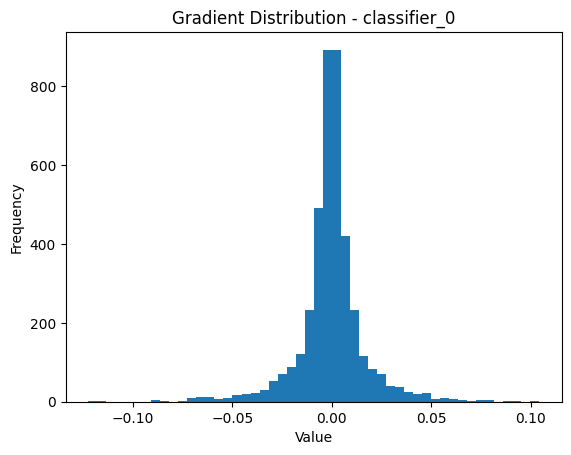

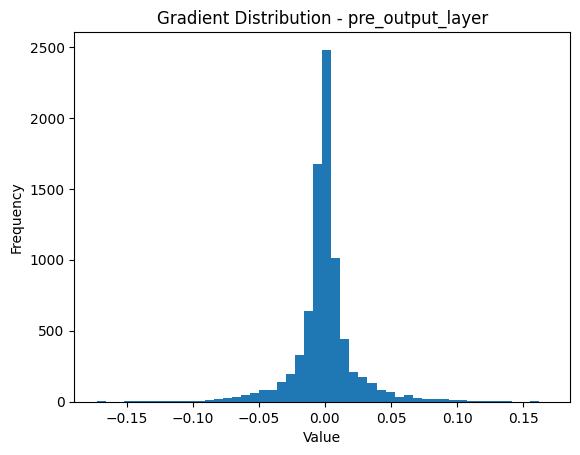

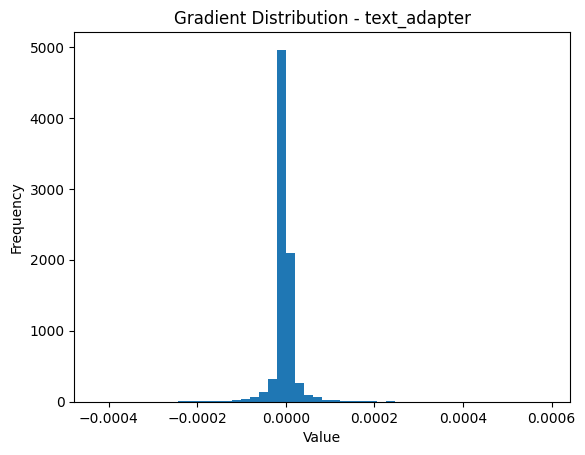

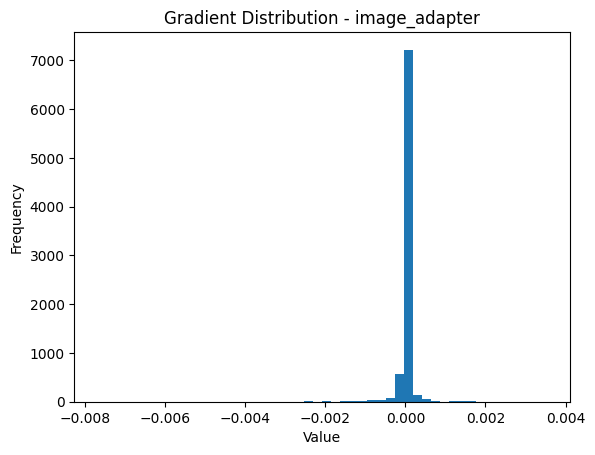

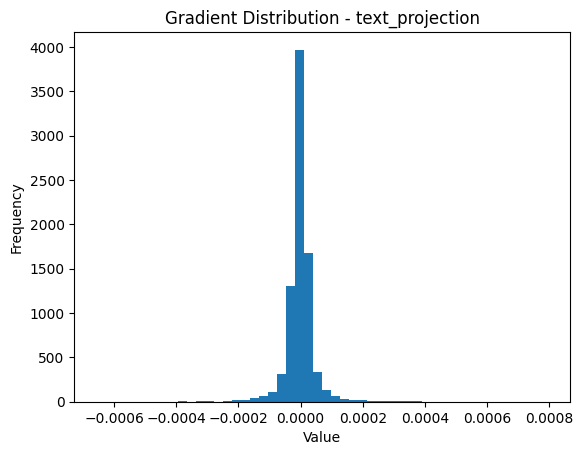

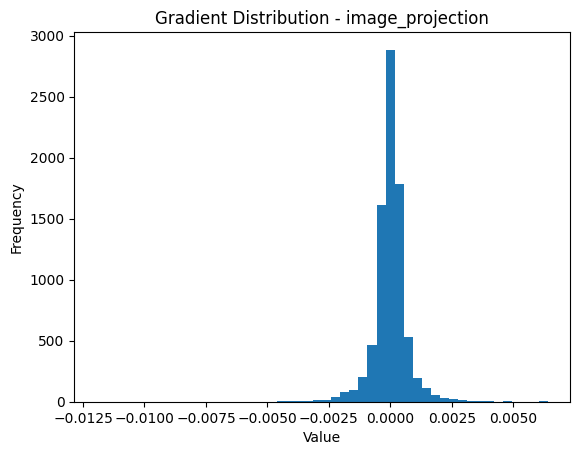

In [19]:
import matplotlib.pyplot as plt

def plot_gradient_distribution(grad, layer_name):
    plt.hist(grad.cpu().numpy().flatten(), bins=50)
    plt.title(f"Gradient Distribution - {layer_name}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

for name, grad in model.gradients.items():
    plot_gradient_distribution(grad, name)